In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
from tempfile import gettempdir
from six.moves import urllib
from sklearn.manifold import TSNE

## Data Preparation

#### 혹시 보유하고 있는 데이터를 직접 사용하고 싶으시다면, 가지고 있는 데이터를 읽은 후, 단어 단위로 분리된 list를 만들어주시는 것으로 아래 내용을 대체하면 됩니다.

##### maybe_download(filename, expected_bytes) :

함수를 통해 설정한 url 주소에 있는 파일을 다운로드 하여 읽어옵니다.

In [4]:
url = 'http://mattmahoney.net/dc/'

# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
  
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
    statinfo = os.stat(local_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
    return local_filename


filename = maybe_download('text8.zip', 31344016)

8757248


Exception: Failed to verify /var/folders/v2/bqvr3rnx461dppw5ldtjlczr0000gn/T/text8.zip. Can you get to it with a browser?

##### read_data(filename): 

다운로드한 파일을 읽은 후, 띄어쓰기 단위로 단어를 분리하여 return 하는 함수

tf.compat.as_str을 사용하여 split 함수로 분리된 단어들을 string 형의 tensorflow 반환시킵니다.

In [ ]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

위의 두 함수를 이용하여 아래 블록을 제작하였습니다.

maybe_download 함수를 통하여 다운 받은 함수를 띄어쓰기 단위로 텍스트를 분리하여 corpus를 구성합니다.

메모리 관리를 위해 모든 corpus를 사용하지 않고, 앞에서부터 10000개만 사용하도록 하겠습니다.

In [ ]:
corpus = read_data(filename)
vocab_part=corpus[0:10000]
print('Data size', len(corpus))
#corpus

##### word_list와 word_dict 준비

우리가 구축한 corpus는 현재 단어들의 중복을 포함한 단어들의 모음입니다.
중복 없이, 우리가 가지고 있는 단어들에 대한 사전(vocabulary)를 만들기 위해 아래와 같은 작업을 하겠습니다.

특정 자료 X에 대하여 list(set(X))를 진행하면, 중복된 내용이 제거된 리스트로 변경가능합니다.

set 자료형은 중복을 허용하지 않기 때문에, 이런 강제형변환은 자주 쓰입니다.

유의할 점은 set 자료형은 순서 또한 가지고 있지 않으므로, list(set(X))를 사용할 경우, 순서 정보가 모두 없어지고, 기존 순서가 뒤죽박죽된다는 점입니다. 유의하세요!

In [5]:
corpus = " ".join(vocab_part).split()
word_list = list(set(corpus))

우선 우리가 읽은 텍스트에 대하여 중복이 없는 단어 사전을 만들었습니다. (word_list)
각 단어들을 모델로 사용하기 위해서는 각각의 단어 내용 자체를 이용하기 보다는, 각 단어에 index를 부여하여 관리하는 것이 편합니다. (여러 자료 구조나 list로 접근할 때는 index가 필요합니다.)

따라서 각 단어를 key로 하고, 우리가 구성한 word_list에서 해당 단어가 몇 번째로 저장되어 있는지를 알려주는 딕셔너리 (dictionary) 자료형을 아래와 같이 만들어 보겠습니다.

word_dict = word_list와 index를 모아놓은 dictionary 타입의 데이터

In [6]:
#corpus set을 dictionary형태로 index와 함께 저장
word_dict = {w: i for i, w in enumerate(word_list)}
word_index = [word_dict[word] for word in word_list]

### skip_grams 모델을 사용하기 위한 준비

우선, skip grams 모델을 사용하기 위해 [target 단어, 주위단어]의 pair를 저장할 공간을 만들겠습니다.

target 단어를 기준으로, 주위 몇 개의 단어를 맥락으로 인식할 지를 결정해야합니다.

주의 몇 개에서 몇 개를 span이라는 이름으로 설정하겠습니다.

span = target으로부터 주변 몇개 단어를 볼 지 결정

In [1]:
skip_grams = []
span=3

이제 우리가 만든 skip_grams 리스트에 학습에 사용할 데이터 (target 단어, 주위 단어)를 준비해보겠습니다.

우리가 읽은 텍스트의 단어인 corpus를 이용하여 데이터를 준비해야겠죠?

우리가 span 개의 주위 단어를 맥락으로 볼 때, target 단어는 3번째 단어부터 (전체 corpus 길이 - span) 번째 단어까지 설정할 수 있습니다. (index는 0번째 단어부터 입니다.)

그렇다면 반복문을 돌면서, target 단어, 그리고 앞 뒤 span 개 만큼을 주위 단어로 설정하면서 skip_grams에 추가하면 되겠죠?

[target, context]형태로 단어를 skip_grams에 저장

In [3]:
for i in range(span, len(corpus) - span):
    target = word_dict[corpus[i]]
    
    for j in range(1,span+1):
        assert i-j >= i or i+j <= i or i-j <0 or i+j > len(corpus)
        context = [word_dict[corpus[i-j]], word_dict[corpus[i+j]]]
        
        for w in context:
            skip_grams.append([target, w])

NameError: name 'corpus' is not defined

### mini-batch 학습을 위한 random_batch 함수 구현

여기까지 오셨으면, 우리가 기본적으로 사용할 skip gram의 훈련 데이터는 모두 준비가 되었습니다.

딥러닝 모델은 일반적으로 모든 데이터를 한 번에 학습시키지 않고, batch_size를 결정하여 batch 단위로 학습을 합니다.

본격적인 모델 학습을 진행하기 전에 batch 단위로 학습할 수 있도록, 우리가 가진 데이터에서 원하는 크기만큼 랜덤으로 훈련 데이터를 추출하는 함수를 만들어 보겠습니다.

np.random.choice(list, size)를 이용하면, list안에서 무작위로 size개를 추출한 list를 리턴받을 수 있습니다!

skip_grams에 담겨있는 [target, context] pair를 무작위로 추출해서 batch 생성

In [9]:
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

### Hyper-parameter 설정

이제 본격적으로 딥러닝 모델 학습에 사용할 하이퍼 파라미터를 설정해보겠습니다.

* training_epoch : 훈련할 epoch 수를 설정합니다. epoch은 (전체 데이터 크기)/(batch_size)를 의미합니다.
* learning_rate : 모델 학습에 사용할 학습률을 결정합니다.
* batch_size : 파라미터 1회 업데이트에 사용할 훈련 데이터의 샘플 개수 입니다.
* embedding_size : 우리가 가지고 있는 단어들을 몇 차원의 벡터로 표현할 지 (embedding) 결정합니다.
* num_sampled: skip-gram 방식의 word embedding에서 사용하는 nce_loss 함수에서 사용할 negative 샘플링의 크기 입니다.
* voc_size = len(word_list) : 우리가 가지고 있는 단어 사전의 크기 입니다.

In [10]:
training_epoch = 3000
learning_rate = 0.001
batch_size = 100
embedding_size = 100
num_sampled = 100
voc_size = len(word_list)

### Word Embedding Model

이제 우리가 학습시킬 word embedding 모델을 만들어 보겠습니다.

결국 우리가 하고 싶은 것은 voc_size의 크기를 갖는 one-hot representation으로 표현된 단어를 embedding_size의 벡터로 표현하는 것입니다.

학습이 완료되어, 우리가 모든 단어들에 대해 embedding 결과를 알고 있다고 가정해볼까요?

그렇다면, 궁극적으로 우리가 얻고 싶은 것은 [단어 총 개수(voc_size) x (embedding_size)] 의 크기를 같은 표입니다.

이 표 안에 각각의 단어들의 embdding 결과가 들어있겠죠?

이 표를 embeddings 라고 이름 짓고, 이제 모델을 만들어보겠습니다.

* embeddings : [단어 총 개수(voc_size) x (embedding_size)]로 단어가 벡터화 된 결과를 저장

* selected_embed : embeddings 에서 특정 row를 읽어옴


#### tf.embedding_lookup 은 ?

우리가 여기서 유용하게 사용할 함수는 바로 tensorflow에 내장되어 있는 tf.embedding_lookup 이라는 함수입니다.

* tf.embedding_lookup(embeddings, inputs)

tf.embedding_lookup은 말 그대로 우리가 학습한 embedding 결과를 쳐다봐서 읽어오는 (lookup) 기능을 합니다.

즉, 우리가 inputs에 입력한 단어의 index를 보고

해당 index에 대응되는 단어들의 벡터 표현을 embeddings에서 읽어오는 함수입니다.

(embeddings가 우리가 가지고 있는 모든 단어들의 벡터화 결과를 저장하고 업데이트하는 Variable이라는 것을 잊지마세요)

본격적으로 모델 구성을 해보겠습니다.

사실, 데이터만 준비되어 있으면 tensorflow를 통해 word embedding 모델을 구현하는 것은 매우매우매우 쉽습니다.

우선 input layer는 우리가 학습시킬 batch_size 개의 단어들이 들어가야합니다.

이 때, label은 차원을 2차원으로 바꾸어주어야합니다. 즉, label의 경우 (batch_size, )이 아닌 (batch_size, 1)의 shape으로 변경해주어야합니다.

그 이유는, 우리가 word_embedding의 학습에서 사용하는 nce_loss가 2차원에 대해 작동하기 때문입니다.

이 후, 학습의 대상인 embeddings를 우선 랜덤한 값으로 설정해주고요.

embedding 결과에 따라 nce_loss를 계산한 후, 유사한 맥락의 단어가 가까운 곳에 위치하도록 학습을 진행해주면 됩니다.

nce_loss를 사용하기 위해 nce_weights, nce_baises 역시 variable로 선언한 후, tf.nn.nce_loss를 통해 loss를 정의하였습니다.

optimizer는 Adam Optimizer를 사용하도록 하겠습니다.

In [4]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])

# tf.nn.nce_loss 를 사용하려면 출력값을 [batch_size, 1] 구성
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])


embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)


nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

NameError: name 'tf' is not defined

### Training the Model with Skip Grams

이제 우리가 선언한 tf.variable 들을 초기화 한 후,
반복문을 통하여 지속적으로 embedding 변수를 학습하도록 하겠습니다.

우리가 위에서 선언한 loss를 minimize하도록 train 모듈만 반복하여 실행시켜주시면 됩니다.

In [12]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 100 == 0:
            print("loss at step ", step, ": ", loss_val)

    trained_embeddings = embeddings.eval()

loss at step  100 :  304.943
loss at step  200 :  262.264
loss at step  300 :  224.42
loss at step  400 :  226.033
loss at step  500 :  205.514
loss at step  600 :  189.429
loss at step  700 :  190.331
loss at step  800 :  160.513
loss at step  900 :  163.235
loss at step  1000 :  94.6013
loss at step  1100 :  94.8371
loss at step  1200 :  99.9007
loss at step  1300 :  82.7357
loss at step  1400 :  69.9089
loss at step  1500 :  66.6783
loss at step  1600 :  48.189
loss at step  1700 :  58.469
loss at step  1800 :  30.6117
loss at step  1900 :  23.4314
loss at step  2000 :  29.5092
loss at step  2100 :  34.0883
loss at step  2200 :  24.1354
loss at step  2300 :  20.4113
loss at step  2400 :  22.7064
loss at step  2500 :  18.9007
loss at step  2600 :  15.1038
loss at step  2700 :  18.6026
loss at step  2800 :  17.3926
loss at step  2900 :  17.6944
loss at step  3000 :  12.1327


### Visualization of Embedding Results

이제 우리가 학습한 embedding 결과를 시각화해볼까요?

다양한 방법이 있지만, 가까운 거리에 위치한 단어들을 적은 차원으로 mapping하는 방법 중 하나인 T-SNE 방법을 사용하겠습니다. 

('티 스니' 라고 주로 읽습니다.)

TSNE는 sklearn에서 제공하고 있는 모듈을 사용하도록 하겠습니다.

우리가 학습한 embedding 결과를 2차원으로 mapping하여 시각화해볼까요?

In [13]:
model=TSNE(n_components=2, random_state=0)
two_d_embeddings=model.fit_transform(trained_embeddings)

모든 단어를 시각화하기 힘드니 우리가 학습한 단어 중 일부만 시각화해보도록 하겠습니다.

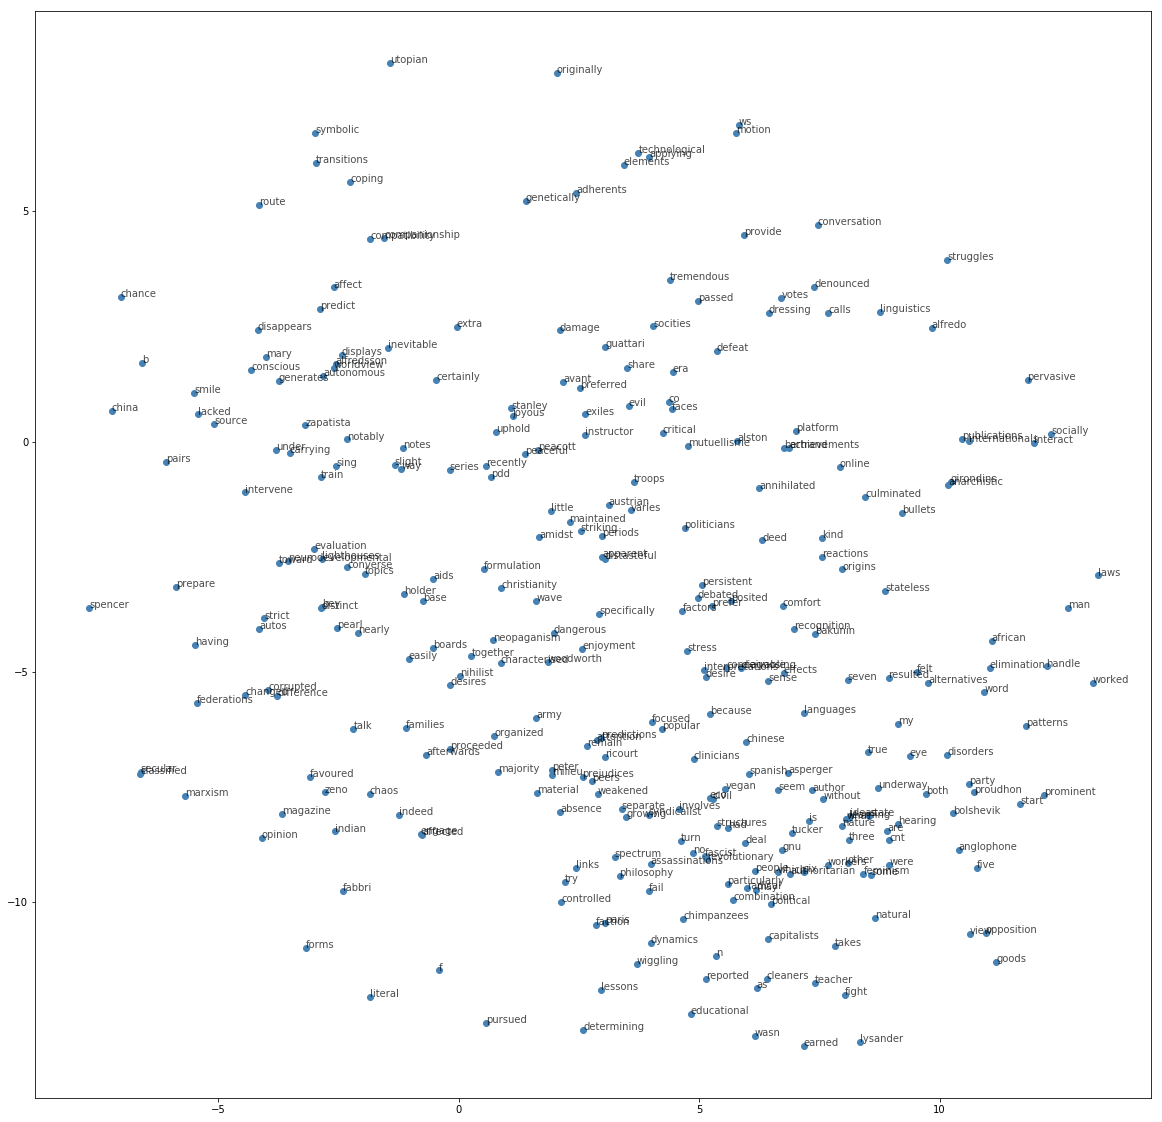

In [14]:
viz_word=300
fig, ax = plt.subplots(figsize=(20, 20))
for idx, label in enumerate(word_list):
    plt.scatter(*two_d_embeddings[idx, :], color='steelblue')
    plt.annotate(label, (two_d_embeddings[idx, 0], two_d_embeddings[idx, 1]), alpha=0.7)
    if idx>viz_word:
        break;
plt.show()

여기까지 진행하면 skip-gram 방식을 통하여 word embedding하는 예제가 종료되었습니다.
loss 값이 충분히 낮아지면, 맥락상 함께 사용되는 비슷한 의미의 단어들이 유사한 공간에 표현되는 것을 확인해 볼 수 있습니다.

그렇지 않다면?

- 우리가 사용하고 있는 데이터셋이 충분하거나, 제대로 구성되었는지 확인해보세요.
- 학습이 충분히 되지 않았을 경우, 하이퍼파라미터를 조정해가며 학습을 반복해보세요.

### 아직 추가되지 않은 사항
- 학습을 반복할 때, 특정 단어 주위에 있는 k 개의 이웃 단어들을 주기적으로 프린트 아웃하는 기능